# Analysis of Custom-KinFragLib 

## Aim of this notebook

Plotting results of Custom-KinFragLib for the paper. 

## Table of contents

1. Library sizes

2. Fragment space 

    2.1 t-SNE plot
    
    2.2 Clustering coverage 

## Imports and preprocessing

In [252]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, MACCSkeys
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np 
from collections import Counter


from kinfraglib import filters, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"

In [41]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")
fragment_library = filters.prefilters.pre_filters(fragment_library_original)


In [6]:
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")

### 1. Library sizes
#### 1.1 Pre-filtered vs custom library size

In [250]:
SUBPOCKET_COLORS = {
    "AP": "purple",
    "FP": "forestgreen",
    "SE": "c",
    "GA": "tab:orange",
    "B1": "tab:blue",
    "B2": "darkslateblue",
}

def plot_n_fragments_per_subpocket(
    n_fragments_per_subpocket, n_fragments_per_subpocket_custom
):
    """
    Plot number of fragments and deduplicated fragments per subpocket.
    """
    plt.figure(figsize=(8, 8))
    ax1 = plt.bar(
        SUBPOCKET_COLORS.keys(),
        n_fragments_per_subpocket,
        fill=False,
        edgecolor=SUBPOCKET_COLORS.values(),
    )
    plt.bar(
        SUBPOCKET_COLORS.keys(),
        n_fragments_per_subpocket_custom,
        color=SUBPOCKET_COLORS.values(),
    )
    plt.legend(["KinFragLib\nfragments", "Custom-KinFragLib\nfragments"], fontsize=17)
    plt.ylabel("# Fragments", fontsize=17)
    plt.xlabel("Subpocket", fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Add absolute numbers of custom-kinfraglib fragments on top 
    bars = ax1.patches

    for bar, label in zip(bars, n_fragments_per_subpocket_custom):

        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            label,
            ha="center",
            va="bottom",
            fontsize=17,
            color="black",
        )

    plt.savefig(f"figures/n_fragments_per_subpocket.png", dpi=300, bbox_inches="tight")

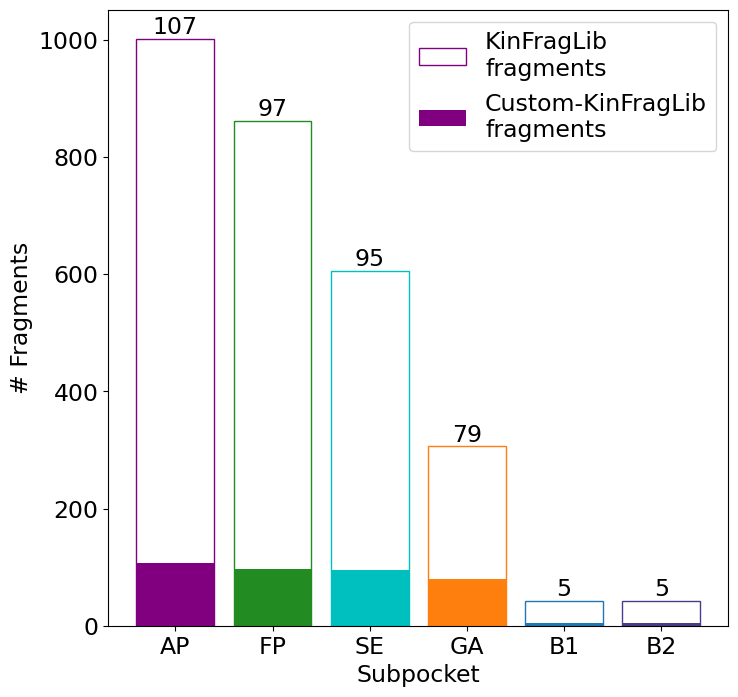

In [251]:
n_fragments_per_subpocket_prefiltered = [len(fragments.drop_duplicates('smiles')) for _, fragments in fragment_library.items()]
n_fragments_per_subpocket_custom = [len(fragments) for _, fragments in fragment_library_custom.items()]
plot_n_fragments_per_subpocket(n_fragments_per_subpocket_prefiltered, n_fragments_per_subpocket_custom)

#### 1.2 Number of fragments after each filtering step 

In [328]:
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"
filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv")

In [372]:
def num_frags_development(filter_res):
    """
    Count the number of fragments passing each custom filter step

    ----------
    filter_res : dataframe
        Contains the calculated values and the boolean for each filtering step if a fragment was
        accepted or not.

    Returns
    ---------
    dataframe
        with the number of fragments per subpocket for each filtering step

    """
    # get the column names
    frag_keys = filter_res.keys()
    frag_keys.to_list()
    # keep only the boolean column names (we do not need the computed values here)
    bool_keys = [x for x in frag_keys if "bool" in x and "retro" not in x]
    # create a dataframe to store the number of fragments left after each filtering step
    update_results = pd.DataFrame()
    # add number of fragments for the pre-filtered subset we are starting with
    update_results["pre-filtered"] = filter_res.reset_index().groupby(
        "subpocket", sort=False
    ).size()
    # go through all boolean columns and count the number of fragments passing
    filter_res_all = filter_res.copy()
    for bool_key in bool_keys:
        filter_res_temp = filter_res.loc[filter_res[bool_key] == 1]
        filter_res_all = filter_res_all.loc[filter_res_all[bool_key] == 1]
        update_results[bool_key] = filter_res_temp.reset_index().groupby("subpocket", sort=False).size()
    
    update_results["bool_all"] = filter_res_all.reset_index().groupby("subpocket", sort=False).size()
    filter_res_all = filter_res_all.loc[filter_res_all['bool_retro'] == 1]
    update_results["bool_all_retro"] = filter_res_all.reset_index().groupby("subpocket", sort=False).size()
    # create a bar plot showing the numbers of fragments passing
    ax = update_results.plot.bar(width=0.9)
    fig = ax.get_figure()

    fig.set_figheight(7)
    fig.set_figwidth(13)

    ax.set_xlabel("Subpocket")
    ax.set_ylabel("Number of fragments")
    ax.set_title("Number of fragments remaining for each filtering step")
    plt.savefig(f"figures/n_fragments_filter_step.png", dpi=300, bbox_inches="tight")
    plt.show()
    # return dataframe with number of fragments after each filtering step.
    return update_results

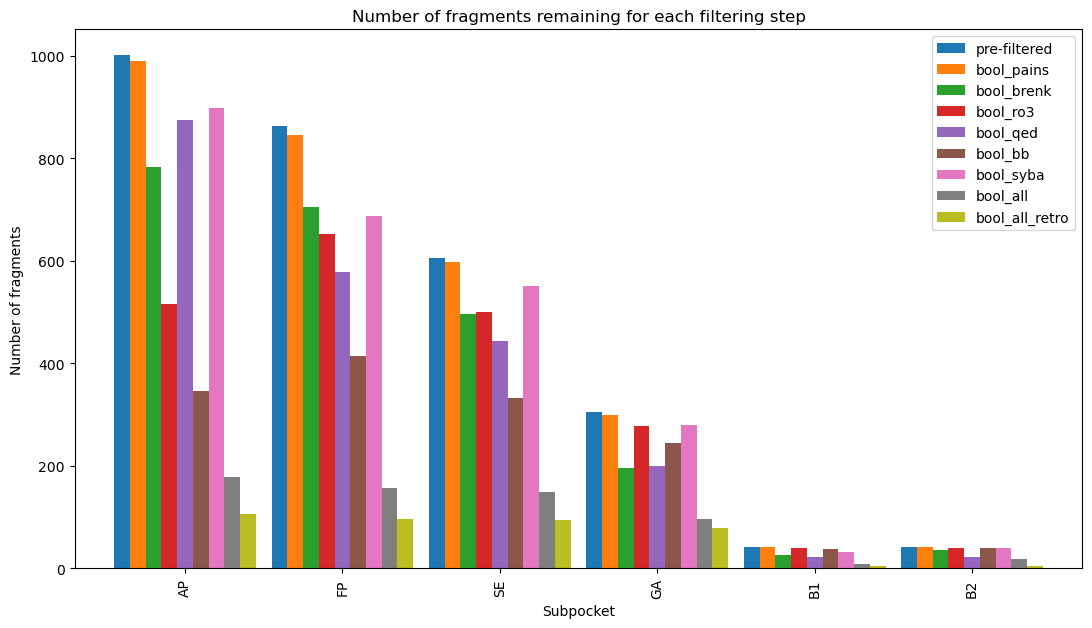

,pre-filtered,bool_pains,bool_brenk,bool_ro3,bool_qed,bool_bb,bool_syba,bool_all,bool_all_retro
subpocket,,,,,,,,,
AP,1001,990,782,516,875,346,898,179,107
FP,862,845,705,653,579,414,688,156,97
SE,606,598,496,500,443,332,550,150,95
GA,306,300,196,278,199,244,280,96,79
B1,42,42,26,39,22,38,32,8,5
B2,42,42,36,40,23,39,39,18,5


In [375]:
num_frags_development(filter_results)

In [376]:
# filters.plots.num_frags_development(filter_results)

### 2. Fragment space 

#### 2.1 t-SNE plot

In [47]:
fragment_library_reduced = utils.read_fragment_library(PATH_DATA / "fragment_library_reduced")

In [48]:
fragment_library = filters.analysis.frag_in_subset(fragment_library, fragment_library_reduced, colname = "bool_reduced")
fragment_library = filters.analysis.frag_in_subset(fragment_library, fragment_library_custom, colname = "bool_custom")

In [241]:
def create_tsne_plots(fragment_library):
    """
    Creates t-SNE plots comparing pre-filtered and custom filtered fragment library.

    ----------
    fragment_library : dict
        fragment library organized in subpockets containing boolean column 
        `bool_custom` defining if the fragments are part of the subsets

    """
    fragment_library_concat = pd.concat(fragment_library).reset_index(drop=True)
    fragment_library_concat["maccs"] = fragment_library_concat.ROMol.apply(MACCSkeys.GenMACCSKeys)

    pca = PCA(n_components=50)
    crds = pca.fit_transform(list(fragment_library_concat["maccs"]))

    crds_embedded = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(crds)

    tsne_df = pd.DataFrame(crds_embedded, columns=["X", "Y"])
 
    tsne_df['custom'] = fragment_library_concat["bool_custom"]

    sns.scatterplot(
        data=tsne_df.query("custom == 0"),
        x="X",
        y="Y",
        color='lightcoral',
        alpha=0.5,
        label="excluded"
    ).set_title("pre-filtered vs. custom KinfragLib fragments")
    sns.scatterplot(
        data=tsne_df.query("custom == 1"),
        x="X",
        y="Y",
        color='green',
        alpha=0.5,
        label="included"
    )

    plt.legend()
    plt.savefig(f"figures/tsne_prefilter_custom.png", dpi=300, bbox_inches="tight")
    plt.show()


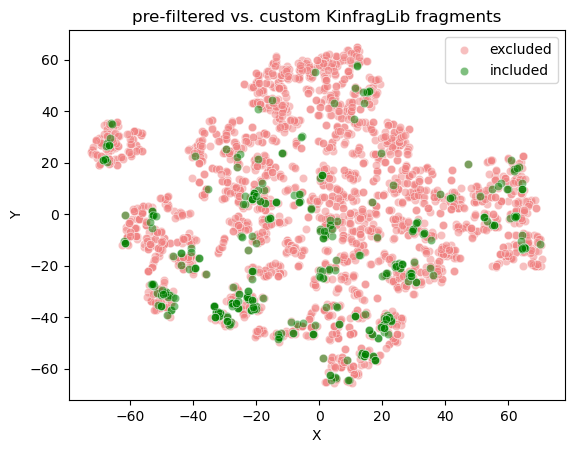

In [242]:
create_tsne_plots(fragment_library)

#### 2.2 Clustering

In [121]:
smiles = pd.concat(fragment_library).smiles.tolist()
smiles_custom = pd.concat(fragment_library_custom).smiles.tolist()

In [236]:
clusters = utils.cluster_molecules(pd.concat(fragment_library).ROMol, cutoff=0.6)

Number of molecules: 2859
Threshold:  0.6
Number of clusters:  453
# Clusters with only 1 molecule:  198
# Clusters with more than 5 molecules:  105
# Clusters with more than 25 molecules:  24
# Clusters with more than 100 molecules:  4


In [237]:
cluster_indexes = []
for smi in smiles_custom: 
    ind = smiles.index(smi)
    cluster_id = clusters[clusters.molecule_id == ind].cluster_id
    cluster_indexes.append(int(cluster_id))


In [238]:
print(f"{len(set(cluster_indexes))} clusters out of {max(clusters.cluster_id)} clusters in total ({round(len(set(cluster_indexes))/max(clusters.cluster_id), 4) * 100} %) are covered in customKinFragLib")

84 clusters out of 453 clusters in total (18.54 %) are covered in customKinFragLib


In [239]:
sum(clusters.cluster_id.isin(cluster_indexes))

1644

In [240]:
sum(clusters.cluster_id.isin(cluster_indexes))/len(smiles)

0.5750262329485835

In [320]:
cluster_counts = Counter(clusters.cluster_id)
custom_cluster_counts = [cluster_counts[c] for c in list(set(cluster_indexes))]
custom_counts = [0, 0, 0, 0, 0]
custom_counts[0] = sum([1 for count in custom_cluster_counts if count == 1])
custom_counts[1] = sum([1 for count in custom_cluster_counts if count > 1])
custom_counts[2] = sum([1 for count in custom_cluster_counts if count > 5])
custom_counts[3] = sum([1 for count in custom_cluster_counts if count > 25])
custom_counts[4] = sum([1 for count in custom_cluster_counts if count > 100])


In [321]:
fragment_counts = [0, 0, 0, 0, 0]
fragment_counts[0] = sum([1 for count in list(cluster_counts.values()) if count == 1])
fragment_counts[1] = sum([1 for count in list(cluster_counts.values()) if count > 1])
fragment_counts[2] = sum([1 for count in list(cluster_counts.values()) if count > 5])
fragment_counts[3] = sum([1 for count in list(cluster_counts.values()) if count > 25])
fragment_counts[4] = sum([1 for count in list(cluster_counts.values()) if count > 100])
#c_200 = sum([1 for count in list(cluster_counts.values()) if count > 100])

In [323]:
columns = ['1', '>1', '>5', '>25', '>100']
fraction = [c/f for (c, f) in zip(custom_counts, fragment_counts)]
df = pd.DataFrame(zip(columns, custom_counts, fragment_counts, fraction), columns=['Count', 'CustomKinFragLib', 'Pre-filtered fragment library', 'Coverage'])

In [327]:
print("Coverage per cluster size:")
df.round({'Coverage': 2})

Coverage per cluster size:


,Count,CustomKinFragLib,Pre-filtered fragment library,Coverage
0,1,9,198,0.05
1,>1,75,255,0.29
2,>5,55,105,0.52
3,>25,19,24,0.79
4,>100,4,4,1.00
